In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:

ROOT = '.data'
#Downloading the CIFAR10 dataset 
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)
#Calculating means and standard deviations for train_data
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


Extracting .data/cifar-10-python.tar.gz to .data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [ ]:
#Using torchvisions.transforms for common image transformations 
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [ ]:
# applying the transformations on train and test data
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
VALID_RATIO = 0.9
#splitting into train and validation data
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

labels = [test_data.classes[i] for i in labels]


In [ ]:
#function for normalising image
def normalize_image(image):
    image_min = image.min()#takes the minimum pixel value of the image
    image_max = image.max()#takes the maximum pixel value of the image
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
BATCH_SIZE = 256

#dataloader to access images in the dataset
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [ ]:
#we first create a ResNet block with two convolutional layers 
#Batch normalisation is performed on output channels

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Initialising the model
        self.downsample = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        #resnet block is initialised    
    def forward(self, x):
        #take x and pass it as input to convolutional layer 1 and perform 2dbatchnorm
        out = F.relu(self.bn1(self.conv1(x)))
        #pass output of convolutional layer 1 to second convolutional layer
        #perform batchnorm for 2nd layer as well
        # int resblock take x and pass it as input to conv1 final output is relu of conv1
        out = self.bn2(self.conv2(out))
        #add the ouptut of second layer to x
        out += self.downsample(x)
        #final output obtained is relu of conv1
        out = F.relu(out)
        return out

class ResNetLayer(nn.Module):
    def __init__(self, block, n_blocks, in_channels, out_channels, stride):
        super().__init__()
        
        #by customising  we define how many blocks should be there in the layer 
        self.modules = []
        #adding the layers
        self.modules.append(block(in_channels, out_channels, stride))
        
        for _ in range(n_blocks-1):
            self.modules.append(block(out_channels, out_channels, 1))
            
        self.blocks = nn.Sequential(*self.modules)
    
    def forward(self, x):
        return self.blocks(x) 
    
class ResNet18(nn.Module):
    def __init__(self, layer, block):
        super().__init__()
        # number of blocks in each layer
        n_blocks = [2, 2, 2, 2]
        #defining layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = layer(block, n_blocks[0], 64, 64, 1)
        self.layer2 = layer(block, n_blocks[1], 64, 128, 2)
        self.layer3 = layer(block, n_blocks[2], 128, 256, 2)
        self.layer4 = layer(block, n_blocks[3], 256, 512, 2)
        self.fc = nn.Linear(512, 10)
        
        #connecting layers
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        #first layer has 64 convolutions
        out = self.layer1(out)
        #then connect 64 to 128 convolutions
        #while changing from layer to layer ,we downsample because during skipconnection we should have same no of channels
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        h = out.view(out.shape[0], -1)
        out = self.fc(h)
        return out, h
    
class ResNet34(nn.Module):
    def __init__(self, layer, block):
        super().__init__()
         # number of blocks in each layer
        n_blocks = [3, 4, 6, 3]
        #defining layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = layer(block, n_blocks[0], 64, 64, 1)
        self.layer2 = layer(block, n_blocks[1], 64, 128, 2)
        self.layer3 = layer(block, n_blocks[2], 128, 256, 2)
        self.layer4 = layer(block, n_blocks[3], 256, 512, 2)
        self.fc = nn.Linear(512, 10)
        # connecting layers
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        #first layer has 64 convolutions
        out = self.layer1(out)
        #then connect 64 to 128 convolutions
        #while changing from layer to layer ,we downsample because during skipconnection we should have same no of channels
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        h = out.view(out.shape[0], -1)
        out = self.fc(h)
        return out, h

## RESNET 18


In [ ]:
#defining the model
model = ResNet18(ResNetLayer, ResNetBlock)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The ResNet18 model has {count_parameters(model):,} trainable parameters')

The ResNet18 model has 11,173,962 trainable parameters


In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model.apply(initialize_parameters)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetLayer(
    (blocks): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential()
      )
      (1): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [ ]:
#using learning rate finder
class LRFinder(object):
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        self.model_params = copy.deepcopy(model.state_dict())
        self.optim_params = copy.deepcopy(optimizer.state_dict())

    def reset(self):
        self.model.load_state_dict(self.model_params)
        self.optimizer.load_state_dict(self.optim_params)

    def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.1, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                        
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        #setting the gradients of all parameters to zero
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        #passing x and y to device
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()


class ExponentialLR(_LRScheduler):
    
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
#initilaise optimizer with low learning rate
START_LR = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#using cross entropy as loss function
criterion = nn.CrossEntropyLoss()
#initialising adam optimzer with  low learning rate
optimizer = optim.Adam(model.parameters(), lr = START_LR)
#placing the model and loss function on device 
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#Resnet18
END_LR = 10
NUM_ITER = 100
#using learning rate finder to find out best learning rate
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)
lr_finder.reset() 

In [ ]:
#function for plotting learning rate
def plot_lr_finder(lrs, losses, skip_start=10, skip_end=5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
        
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Loss")
    ax.grid(True, 'both', 'x')
    plt.show()


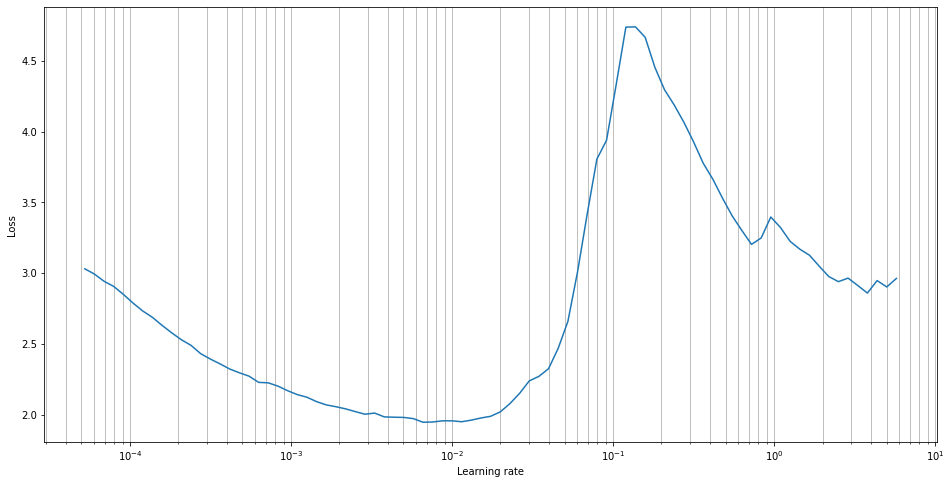

In [ ]:
plot_lr_finder(lrs, losses)

We can then set the learning rates of our model using discriminative fine-tuning - a technique used in transfer learning where later layers in a model have higher learning rates than earlier ones.

In [ ]:
#best learning rate is found from the plot
FOUND_LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [ ]:
#ReduceLROnPlateau scheduler to adjust the learning rate
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 1_000, verbose = True)

In [ ]:
# calculating accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    #training the model
    model.train()
    
    for (x, y) in iterator:
      #x has batch of images
      # y has labels for the batch of images
        # moving x and y to device
        x = x.to(device)
        y = y.to(device)
         #setting the gradients of all parameters to zero
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        #caclulating loss
        loss = criterion(y_pred, y)
        #accuracy is computed
        acc = calculate_accuracy(y_pred, y)
        # back propogating the loss
        loss.backward()
        #updating the optimizer
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
      #x has batch of images
      # y has labels for the batch of images
        # moving x and y to device
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
         
            y_pred, _ = model(x)
            #caclulating loss
            loss = criterion(y_pred, y)
             #accuracy is computed
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#creating empty lists for storing loss and accuracy values while training
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

In [ ]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
 
    end_time = time.time()
    # storing the loss for each epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    #storing the accuarcy for each epoch
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)

    t = time.localtime()
    time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', t)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(time_stamp)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

2021-05-08 18:54:26
Epoch: 01 | Epoch Time: 1m 8s
	Train Loss: 0.369 | Train Acc: 87.08%
	 Val. Loss: 0.674 |  Val. Acc: 78.76%
2021-05-08 18:55:36
Epoch: 02 | Epoch Time: 1m 9s
	Train Loss: 0.348 | Train Acc: 87.63%
	 Val. Loss: 0.602 |  Val. Acc: 80.66%
2021-05-08 18:56:45
Epoch: 03 | Epoch Time: 1m 9s
	Train Loss: 0.330 | Train Acc: 88.42%
	 Val. Loss: 0.637 |  Val. Acc: 80.38%
2021-05-08 18:57:54
Epoch: 04 | Epoch Time: 1m 9s
	Train Loss: 0.304 | Train Acc: 89.35%
	 Val. Loss: 0.693 |  Val. Acc: 79.38%
2021-05-08 18:59:03
Epoch: 05 | Epoch Time: 1m 9s
	Train Loss: 0.291 | Train Acc: 89.67%
	 Val. Loss: 0.607 |  Val. Acc: 81.34%
2021-05-08 19:00:12
Epoch: 06 | Epoch Time: 1m 9s
	Train Loss: 0.273 | Train Acc: 90.55%
	 Val. Loss: 0.626 |  Val. Acc: 81.10%
2021-05-08 19:01:21
Epoch: 07 | Epoch Time: 1m 9s
	Train Loss: 0.257 | Train Acc: 90.90%
	 Val. Loss: 0.629 |  Val. Acc: 81.52%
2021-05-08 19:02:30
Epoch: 08 | Epoch Time: 1m 8s
	Train Loss: 0.248 | Train Acc: 91.36%
	 Val. Loss: 0.

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.613 | Test Acc: 81.95%


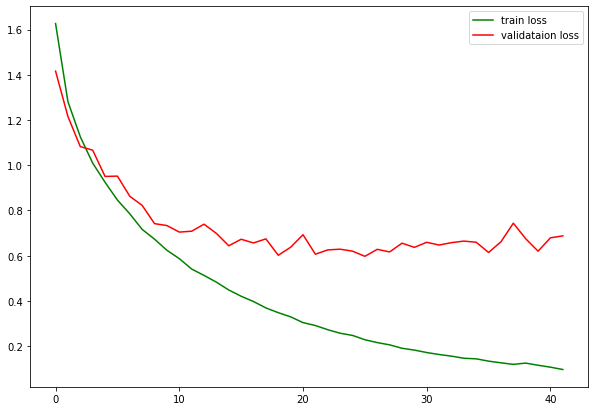

In [ ]:
#plotting the loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='green', label='train loss')
plt.plot(valid_losses, color='red', label='validataion loss')
plt.legend()
plt.show()




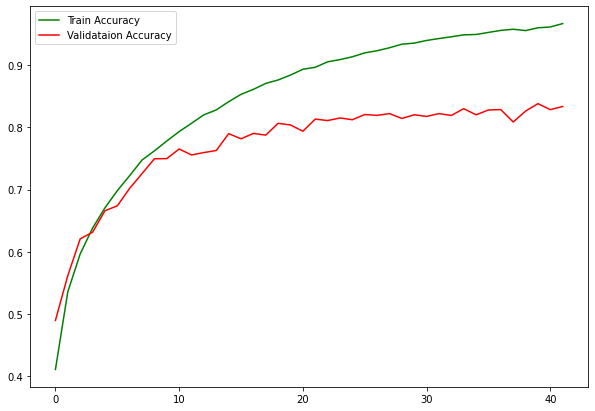

In [ ]:
#Plotting the accuracy
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='Train Accuracy')
plt.plot(valid_accuracy, color='red', label='Validataion Accuracy')
plt.legend()
plt.show()

In [ ]:
# getting the predictions for each image in the dataset
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:

images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation=20)

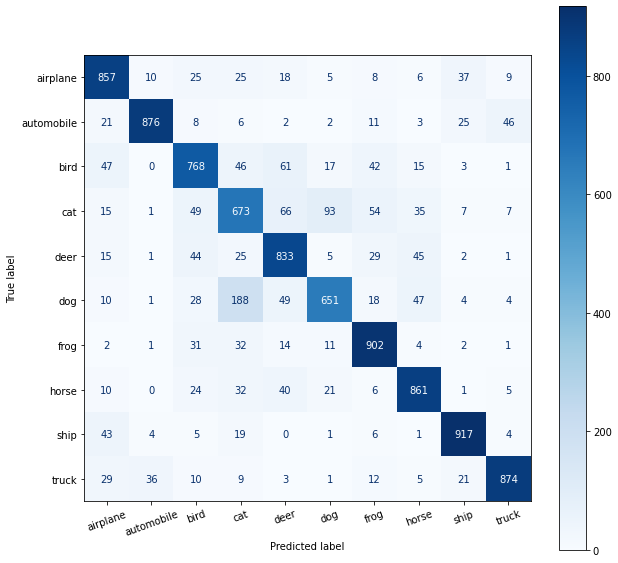

In [ ]:
classes = test_data.classes

plot_confusion_matrix(labels, pred_labels, classes) 

## RESNET 34

In [ ]:
#defining the model
model_2 = ResNet34(ResNetLayer, ResNetBlock)

In [ ]:

print(f'The ResNet 34 model has {count_parameters(model_2):,} trainable parameters')

The ResNet 34 model has 21,282,122 trainable parameters


In [ ]:
model_2.apply(initialize_parameters)



ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetLayer(
    (blocks): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential()
      )
      (1): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [ ]:
#using learning rate finder
class LRFinder(object):
    def __init__(self, model_2, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model_2 = model_2
        self.criterion = criterion
        self.device = device
        
        self.model_params = copy.deepcopy(model_2.state_dict())
        self.optim_params = copy.deepcopy(optimizer.state_dict())

    def reset(self):
        self.model_2.load_state_dict(self.model_params)
        self.optimizer.load_state_dict(self.optim_params)

    def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.1, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                        
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model_2.train()
        #setting the gradients of all parameters to zero
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        #passing x and y to device
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model_2(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()


class ExponentialLR(_LRScheduler):
    
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
#initilaise optimizer with low learning rate
START_LR = 1e-7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#using cross entropy as loss function
criterion = nn.CrossEntropyLoss()
#initialising adam optimzer with  low learning rate

optimizer = optim.Adam(model_2.parameters(), lr = START_LR)
#placing the model and loss function on device
model_2 = model_2.to(device)
criterion = criterion.to(device)

In [ ]:

END_LR = 10
NUM_ITER = 100


lr_finder = LRFinder(model_2, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)
lr_finder.reset()

Stopping early, the loss has diverged


In [ ]:
#function for plotting learning rate
def plot_lr_finder(lrs, losses, skip_start=10, skip_end=5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
        
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Loss")
    ax.grid(True, 'both', 'x')
    plt.show()


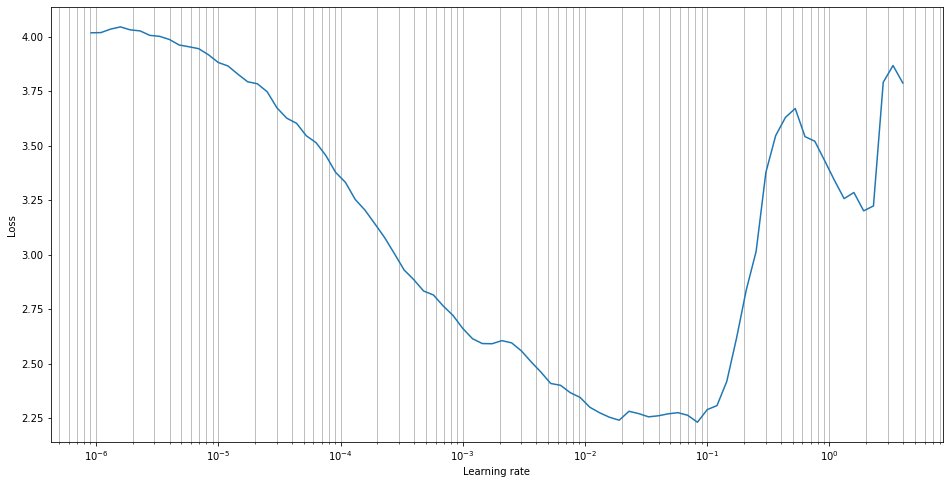

In [ ]:
plot_lr_finder(lrs, losses)    

In [ ]:
#best learning rate is found from the plot
FOUND_LR = 1e-3

optimizer = optim.Adam(model_2.parameters(), lr = FOUND_LR)

In [ ]:
#ReduceLROnPlateau scheduler to adjust the learning rate
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 1_000, verbose = True)


In [ ]:
# calculating accuracy 
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model_2, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    #training the model
    model_2.train()
     #x has batch of images
      # y has labels for the batch of images
    
    for (x, y) in iterator:
        # moving x and y to device
        x = x.to(device)
        y = y.to(device)
         #setting the gradients of all parameters to zero  
        optimizer.zero_grad()
                
        y_pred, _ = model_2(x)
        #caclulating loss
        loss = criterion(y_pred, y)
        #accuracy is computed
        acc = calculate_accuracy(y_pred, y)
        # back propogating the loss
        loss.backward()
         #updating the optimizer
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)    

In [ ]:
def evaluate(model_2, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model_2.eval()
    
    with torch.no_grad():
        #x has batch of images
      # y has labels for the batch of images
        for (x, y) in iterator:
            # moving x and y to device
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model_2(x)
             #caclulating loss
            loss = criterion(y_pred, y)
            #accuracy is computed
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
  

In [ ]:
#creating empty lists for storing loss and accuracy values while training

train_losses2 = []
valid_losses2 = []
train_accuracy2 = []
valid_accuracy2 = []

In [ ]:
EPOCHS = 25



best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_2, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_2, valid_iterator, criterion, device)
    
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_2.state_dict(), 'tut3-model_2.pt')

    end_time = time.time()
       # storing the loss for each epoch
    train_losses2.append(train_loss)
    valid_losses2.append(valid_loss)
    # storing the accuracy for each epoch
    train_accuracy2.append(train_acc)
    valid_accuracy2.append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    t = time.localtime()
    time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', t)
 
    print(time_stamp)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

2021-05-08 20:22:08
Epoch: 01 | Epoch Time: 1m 53s
	Train Loss: 1.326 | Train Acc: 52.74%
	 Val. Loss: 2.009 |  Val. Acc: 58.00%
2021-05-08 20:24:01
Epoch: 02 | Epoch Time: 1m 53s
	Train Loss: 1.000 | Train Acc: 64.64%
	 Val. Loss: 0.970 |  Val. Acc: 68.01%
2021-05-08 20:25:55
Epoch: 03 | Epoch Time: 1m 53s
	Train Loss: 0.785 | Train Acc: 72.52%
	 Val. Loss: 0.701 |  Val. Acc: 75.78%
2021-05-08 20:27:48
Epoch: 04 | Epoch Time: 1m 52s
	Train Loss: 0.644 | Train Acc: 77.48%
	 Val. Loss: 0.762 |  Val. Acc: 73.54%
2021-05-08 20:29:41
Epoch: 05 | Epoch Time: 1m 53s
	Train Loss: 0.561 | Train Acc: 80.46%
	 Val. Loss: 0.647 |  Val. Acc: 78.65%
2021-05-08 20:31:34
Epoch: 06 | Epoch Time: 1m 53s
	Train Loss: 0.503 | Train Acc: 82.44%
	 Val. Loss: 0.597 |  Val. Acc: 80.01%
2021-05-08 20:33:27
Epoch: 07 | Epoch Time: 1m 53s
	Train Loss: 0.458 | Train Acc: 83.94%
	 Val. Loss: 0.555 |  Val. Acc: 81.08%
2021-05-08 20:35:20
Epoch: 08 | Epoch Time: 1m 53s
	Train Loss: 0.411 | Train Acc: 85.72%
	 Val. 

In [ ]:
model_2.load_state_dict(torch.load('tut3-model_2.pt'))

test_loss, test_acc = evaluate(model_2, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Test Loss: 0.356 | Test Acc: 89.18%


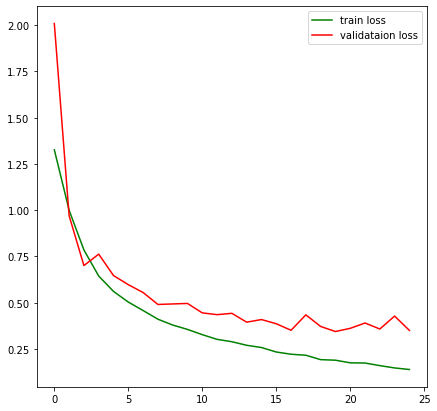

In [ ]:
#plotting the loss
plt.figure(figsize=(7, 7))
plt.plot(train_losses2, color='green', label='train loss')
plt.plot(valid_losses2, color='red', label='validataion loss')
plt.legend()
plt.show()

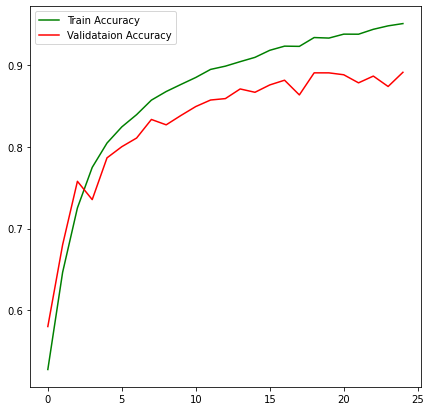

In [ ]:
#plotting the accuracy
plt.figure(figsize=(7, 7))
plt.plot(train_accuracy2, color='green', label='Train Accuracy')
plt.plot(valid_accuracy2, color='red', label='Validataion Accuracy')
plt.legend()
plt.show()

In [ ]:
# getting the predictions for each image in the dataset
def get_predictions(model_2, iterator):

    model_2.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model_2(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model_2, test_iterator)


  

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation=20)


In [ ]:
classes = test_data.classes

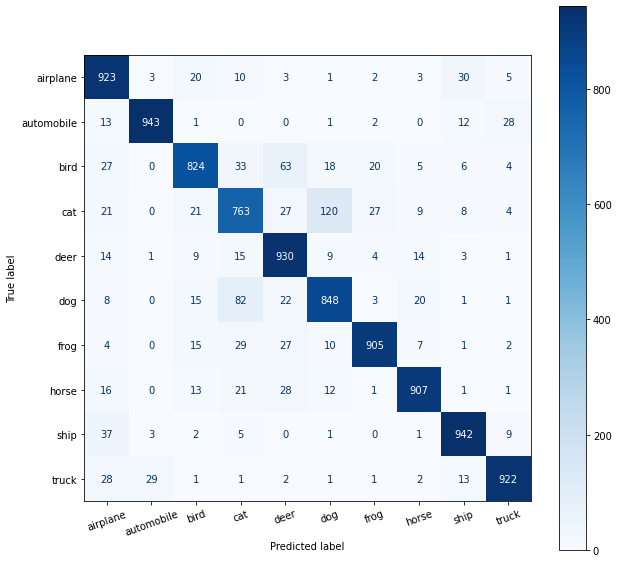

In [ ]:

plot_confusion_matrix(labels, pred_labels, classes)   